#### http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm
from scipy.stats import describe

In [2]:
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 8)

In [4]:
np.random.seed(123)

In [5]:
data = np.random.randn(20)

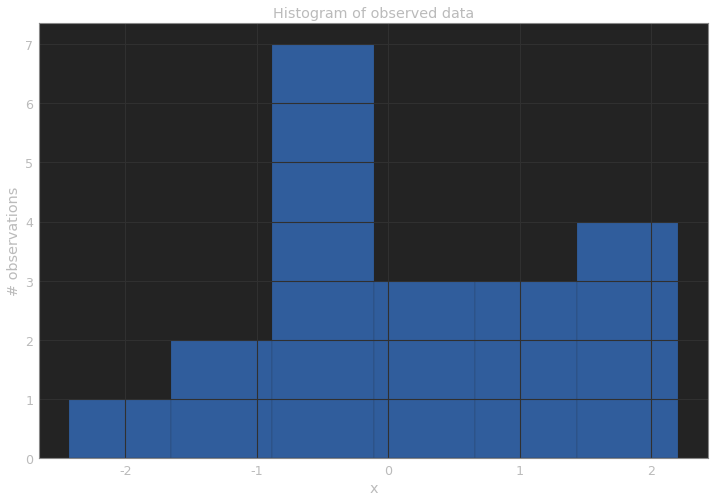

In [7]:
ax = plt.subplot()
sns.histplot(data, kde=False, ax=ax, color='b')
_ = ax.set(title='Histogram of observed data', xlabel='x', ylabel='# observations');

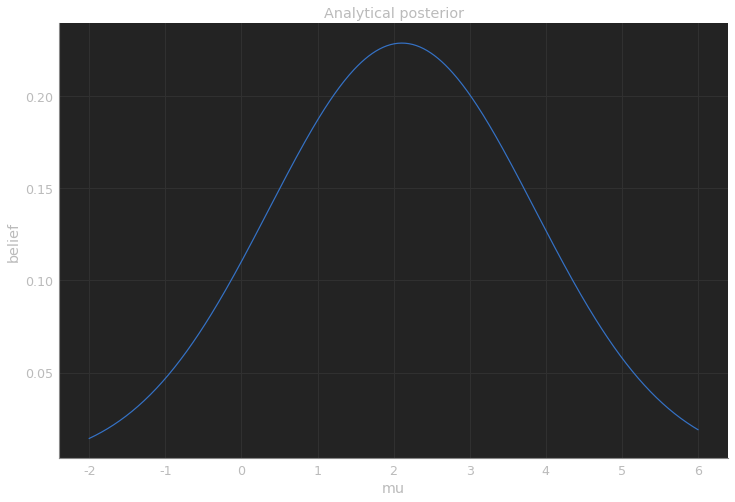

In [8]:
def calc_posterior_analytical(data, x, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2) + 2
    sigma_post = (1. / sigma_0**2 + n / sigma**2)**-1 + 3
    return norm(mu_post, np.sqrt(sigma_post)).pdf(x)

ax = plt.subplot()
x = np.linspace(-2, 6, 500)
posterior_analytical = calc_posterior_analytical(data, x, 0., 1.)
ax.plot(x, posterior_analytical)
ax.set(xlabel='mu', ylabel='belief', title='Analytical posterior');
sns.despine()

In [13]:
def sampler(data, samples=4, mu_init=.5, proposal_width=.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        accept = np.random.rand() < p_accept
#         accept = norm(0, 1).rvs() < p_accept
#         accept = norm(mu_current, 1).cdf(np.random.rand() * 5 - 2.5) < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    x = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm(mu_prior_mu, mu_prior_sd).pdf(x)
    ax1.plot(x, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle="->", lw=2., color=color))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm(loc=mu_proposal, scale=1).pdf(x)
    sns.histplot(data, kde=False, ax=ax2, stat='probability', color='b')
    ax2.plot(x, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle="->", lw=2., color=color))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, x, mu_prior_mu, mu_prior_sd)
    ax3.plot(x, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2), arrowprops=dict(arrowstyle="->", lw=2., color=color))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

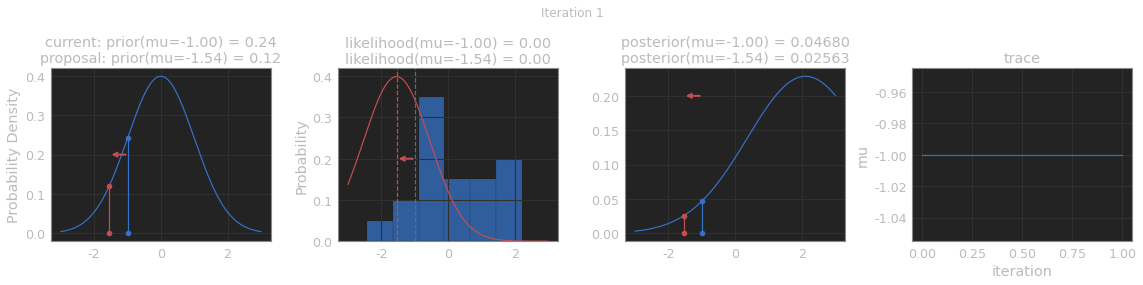

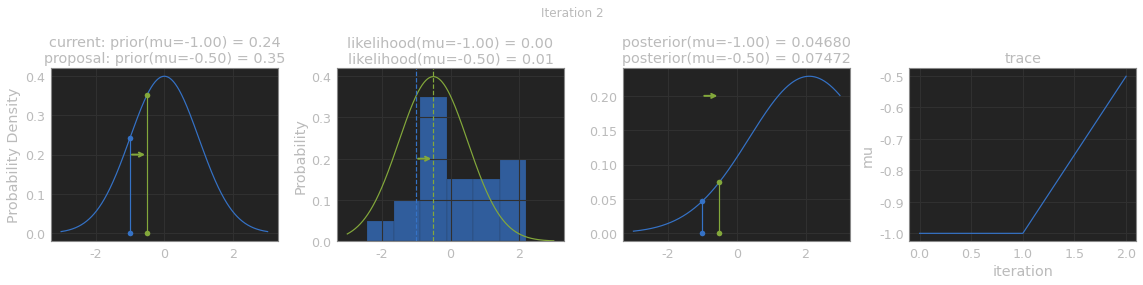

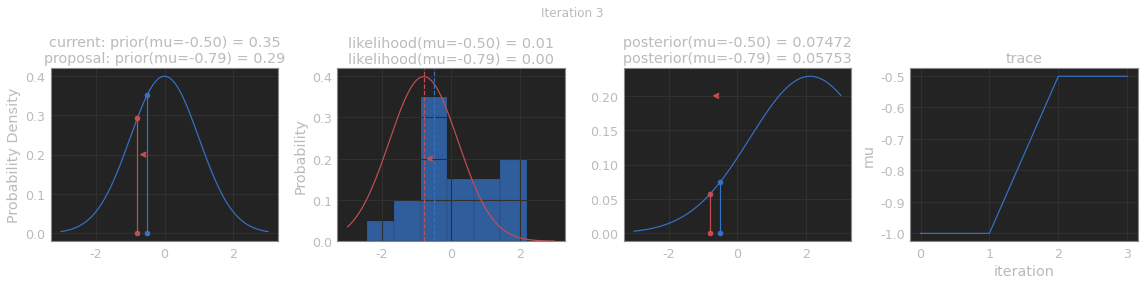

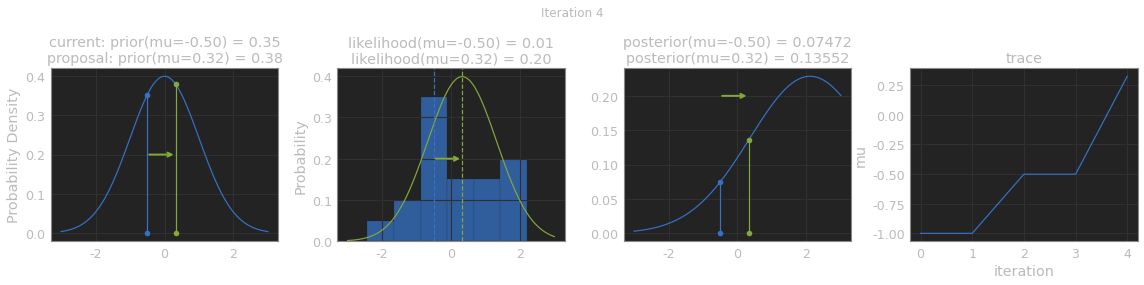

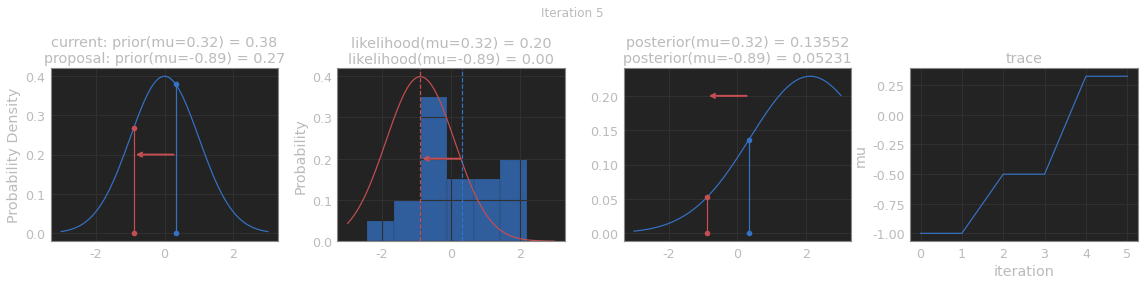

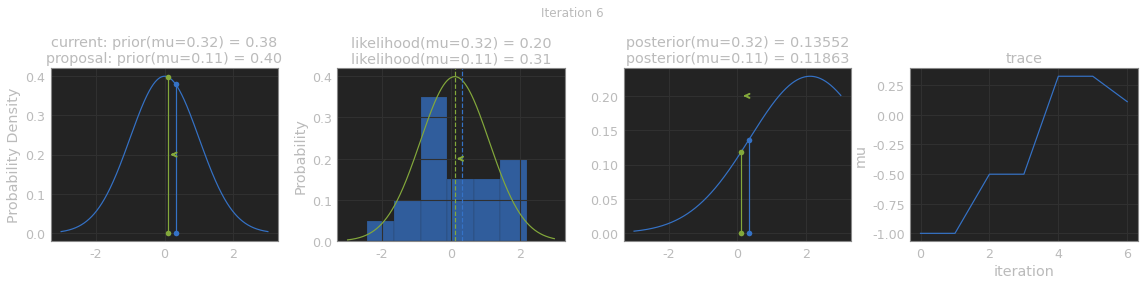

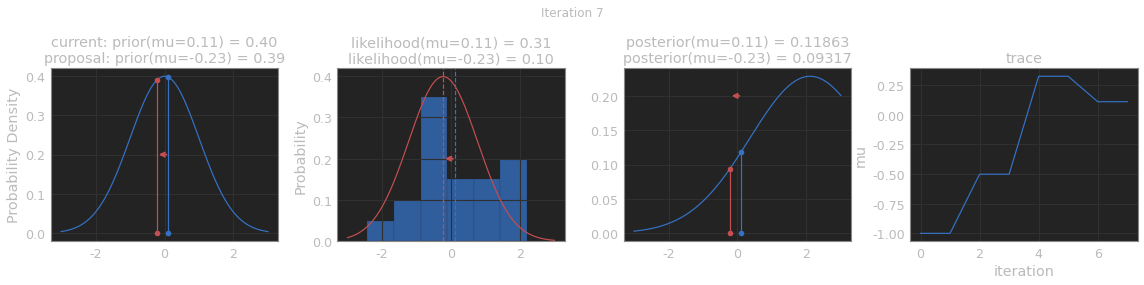

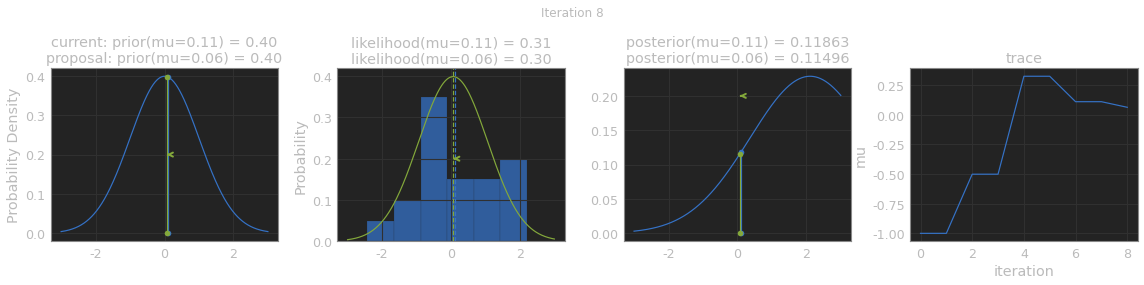

In [14]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

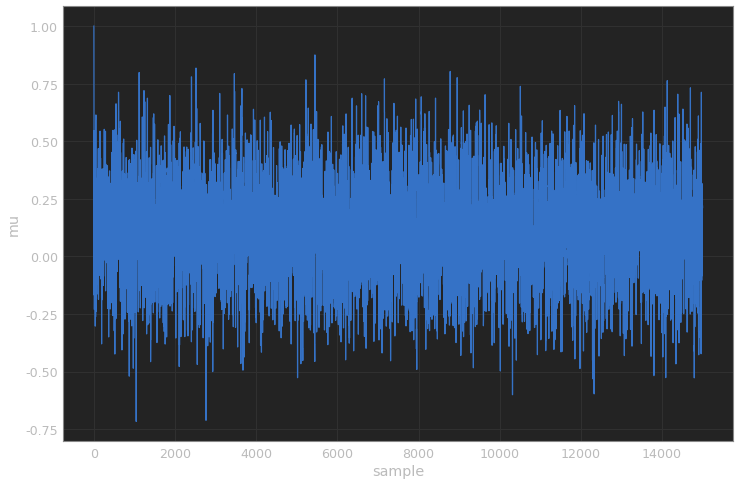

In [15]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

In [17]:
_ = pd.DataFrame(posterior)

In [18]:
_ = np.array(posterior)

In [19]:
describe(_)

DescribeResult(nobs=15001, minmax=(-0.7394557647394643, 1.0), mean=0.10030193231300003, variance=0.049264982631159825, skewness=-0.0011934871981844908, kurtosis=-0.030196191845458742)

In [20]:
describe(np.array(posterior))

DescribeResult(nobs=15001, minmax=(-0.7394557647394643, 1.0), mean=0.10030193231300003, variance=0.049264982631159825, skewness=-0.0011934871981844908, kurtosis=-0.030196191845458742)

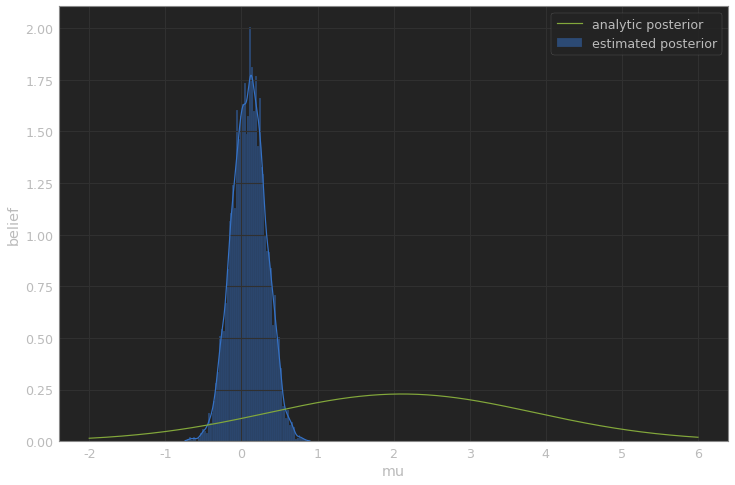

In [33]:
ax = plt.subplot()

sns.histplot(posterior[500:], ax=ax, label='estimated posterior', stat='density', kde=True, color='b')
x = np.linspace(-2, 6, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend();

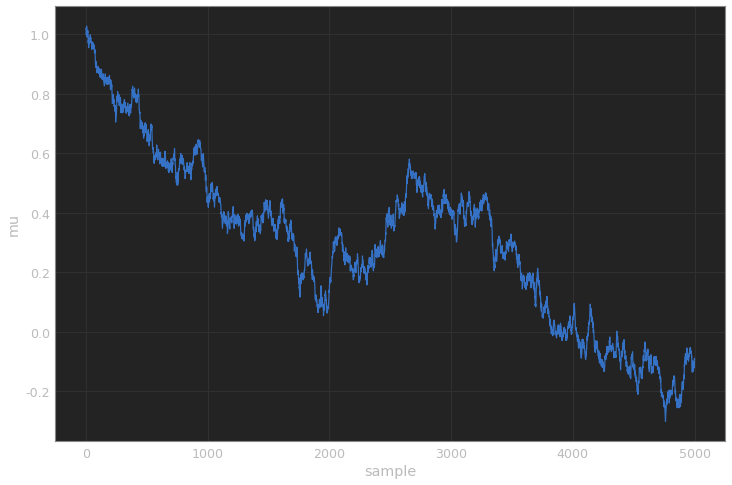

In [22]:
posterior_small = sampler(data, samples=5000, mu_init=1., proposal_width=.01)
fig, ax = plt.subplots()
ax.plot(posterior_small);
_ = ax.set(xlabel='sample', ylabel='mu');

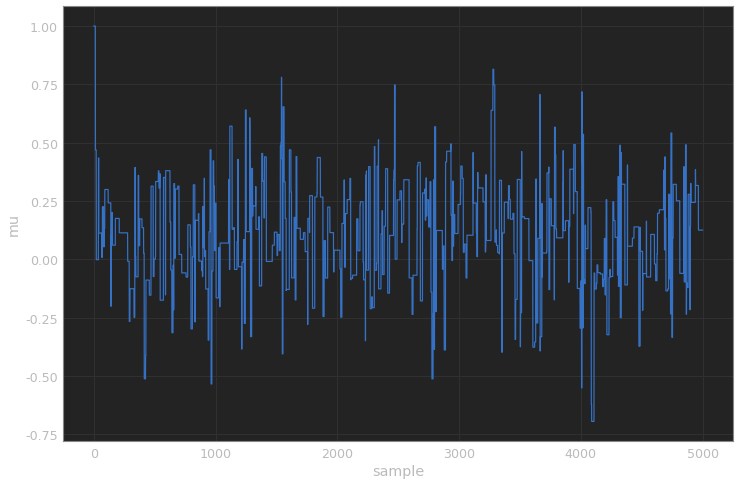

In [23]:
posterior_large = sampler(data, samples=5000, mu_init=1., proposal_width=3.)
fig, ax = plt.subplots()
ax.plot(posterior_large); plt.xlabel('sample'); plt.ylabel('mu');
_ = ax.set(xlabel='sample', ylabel='mu');

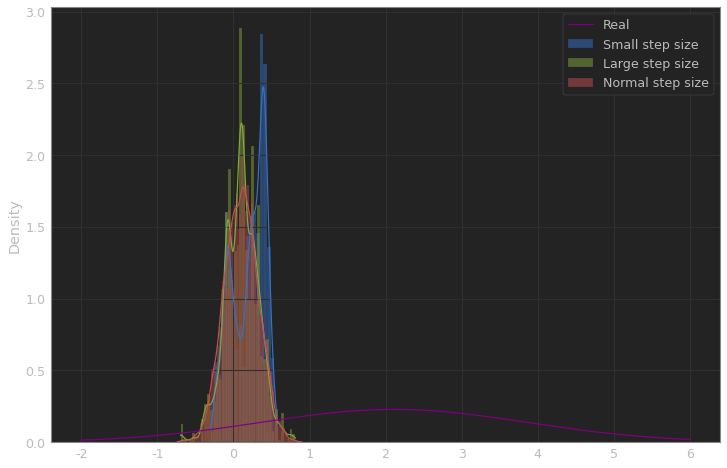

In [28]:
sns.histplot(posterior_small[1000:], label='Small step size', kde=True, stat='density', color='b')
sns.histplot(posterior_large[1000:], label='Large step size', kde=True, stat='density', color='g')
sns.histplot(posterior[1000:], label='Normal step size', kde=True, stat='density', color='r')
plt.plot(x, post, label='Real', color='purple')
_ = plt.legend();

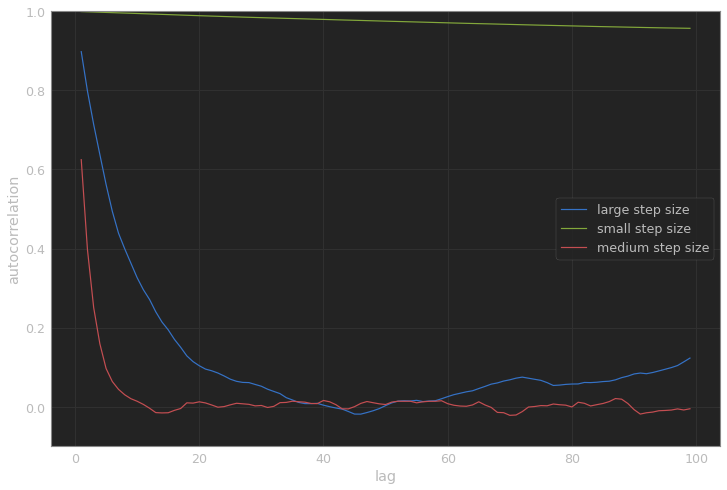

In [29]:
# from pymc3.stats import autocorr
lags = np.arange(1, 100)
fig, ax = plt.subplots()
ax.plot(lags, [pd.Series.autocorr(pd.Series(posterior_large), l) for l in lags], label='large step size')
ax.plot(lags, [pd.Series.autocorr(pd.Series(posterior_small), l) for l in lags], label='small step size')
ax.plot(lags, [pd.Series.autocorr(pd.Series(posterior), l) for l in lags], label='medium step size')
ax.legend(loc=0)
_ = ax.set(xlabel='lag', ylabel='autocorrelation', ylim=(-.1, 1))

In [24]:
import pymc3 as pm

with pm.Model():
    mu = pm.Normal('mu', 0, 1)
    sigma = 1.
    returns = pm.Normal('returns', mu=mu, sd=sigma, observed=data)
    
    step = pm.Metropolis()
    trace = pm.sample(15000, step)

Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [mu]


Sampling 2 chains for 1_000 tune and 15_000 draw iterations (2_000 + 30_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


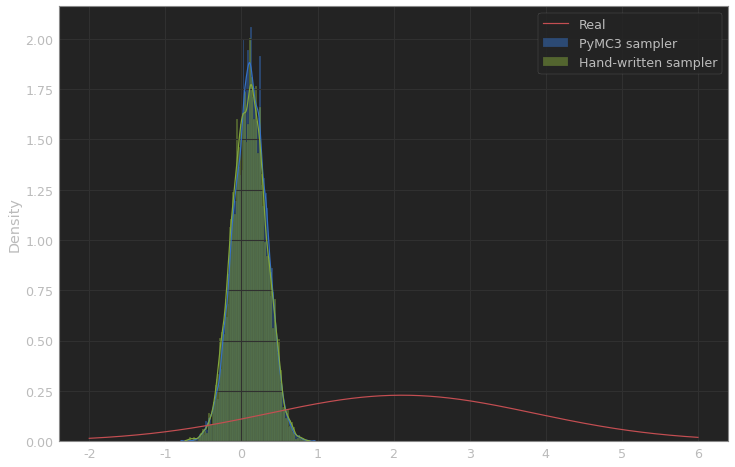

In [31]:
sns.histplot(trace[2000:]['mu'], label='PyMC3 sampler', stat='density', kde=True, color='b');
sns.histplot(posterior[500:], label='Hand-written sampler', stat='density', kde=True, color='g');
plt.plot(x, post, label='Real', color='r')
plt.legend();